In [1]:
import numpy as np
import pickle
import matplotlib.pyplot as plt

In [2]:
# Chargement et inspection des données
def load_data(train_path, test_path):
    # Charger les données d'entraînement
    with open(train_path, 'rb') as f:
        train_data = pickle.load(f)
    #print("Training data keys:", train_data.keys())  # Vérification des clés

    # Charger les données de test
    with open(test_path, 'rb') as f:
        test_data = pickle.load(f)
    #print("Test data keys:", test_data.keys())  # Vérification des clés

    # Identifier les clés correctes
    X_train = train_data.get('images')
    y_train = train_data.get('labels')
    X_test = test_data.get('images')

    if X_train is None or y_train is None or X_test is None:
        raise ValueError("Les données n'ont pas les bonnes clés. Vérifiez votre fichier pickle.")

    # Convertir en tableaux NumPy
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    X_test = np.array(X_test)

    return X_train, y_train, X_test

In [3]:
# Charger les données
train_path = 'train_data.pkl'
test_path = 'test_data.pkl'
X_train, y_train, X_test = load_data(train_path, test_path)

In [4]:
# Séparation des données
np.random.seed(42) # pour assurer la reproductibilité

# Mélanger les indices
indices = np.arange(X_train.shape[0])
np.random.shuffle(indices)

# Calculer la taille de l'ensemble de test
test_size = 0.2 # 20% des données
test_size = int(X_train.shape[0] * test_size)

# Diviser les indices en indices d'entraînement et de validation
train_indices = indices[test_size:]
val_indices = indices[:test_size]

# Extraire les échantillons pour l'entraînement et la validation
X_train, X_val = X_train[train_indices], X_train[val_indices]
y_train, y_val = y_train[train_indices], y_train[val_indices]

print(f"Shape of X_train is:{X_train.shape}")
print(f"Shape of X_val is:{X_val.shape}")
print(f"Shape of y_train is:{y_train.shape}")
print(f"Shape of y_val is:{y_val.shape}")

Shape of X_train is:(77982, 28, 28)
Shape of X_val is:(19495, 28, 28)
Shape of y_train is:(77982,)
Shape of y_val is:(19495,)


In [5]:
# Vérification de la distribution des classes
unique, counts = np.unique(y_train, return_counts=True)
print(f"Distribution des labels dans l'ensemble d'entraînement: {dict(zip(unique, counts))}")

Distribution des labels dans l'ensemble d'entraînement: {0: 26830, 1: 8168, 2: 6213, 3: 36771}


In [6]:
from PIL import Image
from torchvision import transforms
import torch

# Définir les transformations d'augmentation
transform = transforms.Compose([
    transforms.RandomRotation(30),
    transforms.RandomHorizontalFlip(),
    transforms.RandomAffine(degrees=15, translate=(0.2, 0.2)),
    transforms.ToTensor(),  # Convertir en tenseur PyTorch
    transforms.RandomErasing(p=0.5, scale=(0.02, 0.2))  # RandomErasing s'applique sur les tenseurs
])

# Fonction pour augmenter une image
def augment_image(image):
    """
    Augmente une image donnée (NumPy array ou PyTorch tensor).
    Args:
        image: Image en format NumPy array, PyTorch tensor ou PIL.Image.
    Returns:
        Image augmentée sous forme de tenseur PyTorch.
    """
    # Convert to PIL Image only if it's not already
    if not isinstance(image, Image.Image):
        image = Image.fromarray(image)

    # Appliquer les transformations
    augmented_image = transform(image)
    return augmented_image

# Fonction pour augmenter les données
def augment_data(X_class, y_class, target_count):
    augmented_X = []
    augmented_y = []
    current_count = len(X_class)

    while len(augmented_X) + current_count < target_count:
        for i in range(current_count):
            image = X_class[i]
            augmented_image = augment_image(image).numpy()  # Appel à la fonction
            # Reshape to match original dimensions:
            augmented_image = augmented_image.squeeze(0) # Remove the extra dimension
            augmented_X.append(augmented_image)
            augmented_y.append(y_class[i])

            if len(augmented_X) + current_count >= target_count:
                break

    return np.array(augmented_X), np.array(augmented_y)

# Filtrer les indices des classes 1 et 2
indices_class_1 = np.where(y_train == 1)[0]
indices_class_2 = np.where(y_train == 2)[0]

# Extraire les données des classes 1 et 2
X_class_1 = X_train[indices_class_1]
X_class_2 = X_train[indices_class_2]
y_class_1 = y_train[indices_class_1]
y_class_2 = y_train[indices_class_2]

# Déterminer combien d'échantillons ajouter
target_count = 26000

# Augmenter les données pour les classes 1 et 2
X_class_1_aug, y_class_1_aug = augment_data(X_class_1, y_class_1, target_count)
X_class_2_aug, y_class_2_aug = augment_data(X_class_2, y_class_2, target_count)

# Combiner les données d'origine et augmentées
X_train_augmented = np.concatenate((X_train, X_class_1_aug, X_class_2_aug), axis=0)
y_train_augmented = np.concatenate((y_train, y_class_1_aug, y_class_2_aug), axis=0)

# Mélanger les données après augmentation
indices = np.random.permutation(len(X_train_augmented))  # Générer des indices aléatoires
X_train_augmented = X_train_augmented[indices]
y_train_augmented = y_train_augmented[indices]

# Vérifier la nouvelle distribution des labels
unique, counts = np.unique(y_train_augmented, return_counts=True)
print(f"Nouvelle distribution des labels : {dict(zip(unique, counts))}")

Nouvelle distribution des labels : {0: 26830, 1: 26000, 2: 26000, 3: 36771}


In [7]:
# Standardisation
X_train_augmented = (X_train_augmented - X_train.mean(axis=0)) / X_train.std(axis=0)
X_val = (X_val - X_train.mean(axis=0)) / X_train.std(axis=0)
X_test = (X_test - X_train.mean(axis=0)) / X_train.std(axis=0)

In [28]:
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import CosineAnnealingLR

# Vérifiez si le GPU est disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Utilisation de {device}")

# 1. Définir un Dataset personnalisé
class ImageDataset(Dataset):
    def __init__(self, images, labels):
        self.images = torch.tensor(images, dtype=torch.float32).unsqueeze(1)  # Ajouter une dimension pour le canal
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.images[idx], self.labels[idx]

# Création des instances de datasets
train_dataset = ImageDataset(X_train_augmented, y_train_augmented)
val_dataset = ImageDataset(X_val, y_val)

# Création des DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Définir le modèle CNN
class CNNModel(nn.Module):
  def __init__(self, num_classes=4):
      super(CNNModel, self).__init__()
      self.conv_layers = nn.Sequential(
          nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1),
          nn.BatchNorm2d(64),
          nn.ReLU(),
          nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
          nn.BatchNorm2d(128),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=2, stride=2),

          nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
          nn.BatchNorm2d(256),
          nn.ReLU(),
          nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
          nn.BatchNorm2d(512),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=2, stride=2)
      )
      self.fc_layers = nn.Sequential(
          nn.Flatten(),
          nn.Linear(512 * 7 * 7,1024),
          nn.ReLU(),
          nn.Dropout(0.5),

          nn.Linear(1024, 512),
          nn.ReLU(),
          nn.Dropout(0.5),

          nn.Linear(512, 256),
          nn.ReLU(),
          nn.Dropout(0.3),

          nn.Linear(256, num_classes)
      )

  def forward(self, x):
      x = self.conv_layers(x)
      x = self.fc_layers(x)
      return x

model = CNNModel(num_classes=4).to(device)

# Recalculer les poids
class_weights = torch.tensor([1.5, 2, 2.5, 1], dtype=torch.float).to(device)

# Utiliser CrossEntropyLoss avec des poids
criterion = nn.CrossEntropyLoss(weight=class_weights)

# Optimiseur
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Cosine Annealing Scheduler
scheduler = CosineAnnealingLR(optimizer, T_max=10, eta_min=0)

# Fonction pour entraîner le modèle
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=50, early_stop_patience=5):
    """
    Entraîne un modèle avec Cosine Annealing Scheduler et Early Stopping.

    Args:
        model (torch.nn.Module): Le modèle à entraîner.
        train_loader (DataLoader): DataLoader pour l'entraînement.
        val_loader (DataLoader): DataLoader pour la validation.
        criterion: Fonction de perte.
        optimizer: Optimiseur.
        scheduler: Scheduler pour le taux d'apprentissage.
        num_epochs (int): Nombre maximum d'époques.
        early_stop_patience (int): Nombre d'époques sans amélioration avant l'arrêt.

    Returns:
        model (torch.nn.Module): Le modèle avec les meilleurs poids restaurés.
    """
    best_val_loss = float('inf')
    epochs_no_improve = 0
    best_model_state = None

    for epoch in range(num_epochs):
        # Mode entraînement
        model.train()
        running_loss_train = 0.0
        correct_train = 0
        total_train = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss_train += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        train_loss = running_loss_train / len(train_loader)
        train_accuracy = correct_train / total_train

        # Mode validation
        model.eval()
        running_loss_val = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                running_loss_val += loss.item()
                _, predicted = torch.max(outputs, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        val_loss = running_loss_val / len(val_loader)
        val_accuracy = correct_val / total_val

        # Mettre à jour le scheduler
        scheduler.step()

        # Afficher les métriques
        print(f"Epoch {epoch+1}/{num_epochs} | "
              f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy * 100:.2f}% | "
              f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy * 100:.2f}% | "
              f"Learning Rate: {scheduler.get_last_lr()[0]:.6f}")

        # Early Stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_no_improve = 0
            best_model_state = model.state_dict()  # Sauvegarder le meilleur modèle
        else:
            epochs_no_improve += 1

        if epochs_no_improve == early_stop_patience:
            print(f"Arrêt anticipé à l'époque {epoch+1}.")
            break

    # Restaurer le meilleur modèle
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
        print("Meilleur modèle restauré.")

    return model

# Prédictions
def predict(model, dataloader, device):
    model.eval()  # Mode d'évaluation

    all_predictions = []
    with torch.no_grad():
        for batch in dataloader:  # Iterate directly over the batch
            if isinstance(batch, (list, tuple)):  # Check if batch is a tuple (train/val)
                inputs, _ = batch  # Unpack if it's a tuple
                inputs = inputs.to(device)
            else:  # If not, it's a single tensor (test)
                inputs = batch.to(device)

            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            all_predictions.extend(predicted.cpu().numpy())

    return all_predictions

Utilisation de cuda


In [29]:
# Entraînement
best_model = train_model(
    model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=50, early_stop_patience=5
)

Epoch 1/50 | Train Loss: 0.8689, Train Accuracy: 62.53% | Validation Loss: 0.6602, Validation Accuracy: 82.46% | Learning Rate: 0.000976
Epoch 2/50 | Train Loss: 0.6005, Train Accuracy: 79.28% | Validation Loss: 0.5065, Validation Accuracy: 84.57% | Learning Rate: 0.000905
Epoch 3/50 | Train Loss: 0.5012, Train Accuracy: 82.76% | Validation Loss: 0.4561, Validation Accuracy: 86.44% | Learning Rate: 0.000794
Epoch 4/50 | Train Loss: 0.4370, Train Accuracy: 85.15% | Validation Loss: 0.4379, Validation Accuracy: 87.86% | Learning Rate: 0.000655
Epoch 5/50 | Train Loss: 0.3888, Train Accuracy: 86.85% | Validation Loss: 0.3891, Validation Accuracy: 88.94% | Learning Rate: 0.000500
Epoch 6/50 | Train Loss: 0.3419, Train Accuracy: 88.44% | Validation Loss: 0.3897, Validation Accuracy: 89.19% | Learning Rate: 0.000345
Epoch 7/50 | Train Loss: 0.2939, Train Accuracy: 90.07% | Validation Loss: 0.3764, Validation Accuracy: 89.53% | Learning Rate: 0.000206
Epoch 8/50 | Train Loss: 0.2494, Train Ac

In [30]:
from sklearn.metrics import confusion_matrix

pred_val = predict(best_model, val_loader, device)

# Calculer la matrice de confusion
conf_matrix = confusion_matrix(y_val, pred_val)

print("Matrice de confusion :")
print(conf_matrix)

Matrice de confusion :
[[6202   97  285   70]
 [  80 1758   35  172]
 [ 165   35  895  446]
 [  78  112  529 8536]]


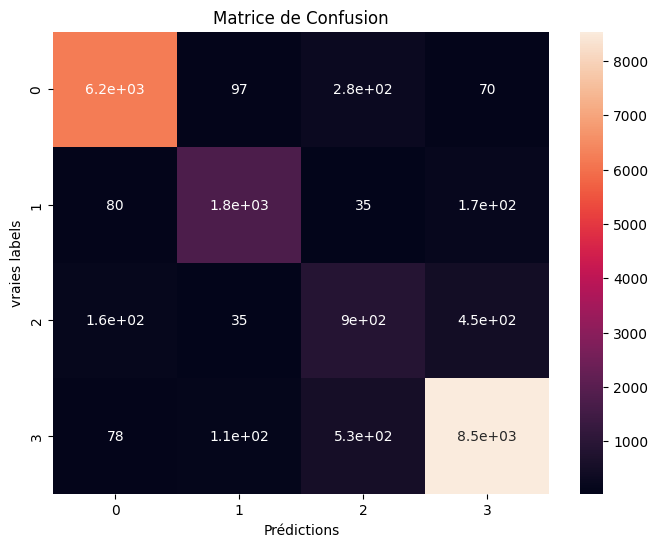

In [31]:
import seaborn as sns

# Afficher la matrice de confusion sous forme de graphique
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True)
plt.xlabel('Prédictions')
plt.ylabel('vraies labels')
plt.title('Matrice de Confusion')
plt.show()


In [32]:
from torch.utils.data import ConcatDataset

# Combiner les ensembles d'entraînement et de validation
combined_dataset = ConcatDataset([train_dataset, val_dataset])

# Créer un nouveau DataLoader pour l'ensemble combiné
combined_loader = DataLoader(combined_dataset, batch_size=32, shuffle=True)

# Entraîner le modèle final sur l'ensemble combiné (entrainement et validation)
def train_final_model(model, combined_loader, criterion, optimizer, num_epochs=10):
    model.train()  # Mode entraînement

    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in combined_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(combined_loader)
        train_accuracy = correct / total

        # Afficher les résultats pour chaque époque
        print(f"Epoch {epoch+1}/{num_epochs} | "
              f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy * 100:.2f}%")

# Appeler la fonction pour entraîner le modèle final
train_final_model(model, combined_loader, criterion, optimizer, num_epochs=10)

Epoch 1/10 | Train Loss: 0.2204, Train Accuracy: 92.78%
Epoch 2/10 | Train Loss: 0.2051, Train Accuracy: 93.26%
Epoch 3/10 | Train Loss: 0.1964, Train Accuracy: 93.65%
Epoch 4/10 | Train Loss: 0.1813, Train Accuracy: 93.98%
Epoch 5/10 | Train Loss: 0.1699, Train Accuracy: 94.38%
Epoch 6/10 | Train Loss: 0.1599, Train Accuracy: 94.65%
Epoch 7/10 | Train Loss: 0.1488, Train Accuracy: 95.08%
Epoch 8/10 | Train Loss: 0.1398, Train Accuracy: 95.29%
Epoch 9/10 | Train Loss: 0.1329, Train Accuracy: 95.51%
Epoch 10/10 | Train Loss: 0.1217, Train Accuracy: 95.87%


In [33]:
# Créer un Dataset personnalisé pour X_test
class TestDataset(Dataset):
    def __init__(self, images):
        self.images = torch.tensor(images, dtype=torch.float32).unsqueeze(1)  # Ajouter une dimension pour le canal

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        return self.images[idx]

# Charger X_test dans un DataLoader
test_dataset = TestDataset(X_test)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Faire des prédictions sur X_test
predictions = predict(model, test_loader, device)

In [34]:
# Génération du fichier de soumission
submission = np.column_stack((np.arange(1, len(predictions) + 1), predictions))
np.savetxt('submission_final.csv', submission, fmt='%d', delimiter=',', header='ID,Class', comments='')
print("Fichier de soumission généré : submission.csv")

Fichier de soumission généré : submission.csv


In [35]:
# Sauvegarder le modèle
torch.save(model.state_dict(), "cnn_model.pth")
print("Modèle sauvegardé sous cnn_model.pth")

Modèle sauvegardé sous cnn_model.pth


In [36]:
from torchvision import transforms

class ImageDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        # Convertir en 3 canaux si l'image est en niveaux de gris
        # Correction : Appliquer la conversion avant la normalisation
        if image.shape[0] == 1:
            image = image.repeat(3, 1, 1)

        return image, label

# Transformation pour redimensionner les images
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    # Correction : Utiliser la normalisation conditionnellement en fonction du nombre de canaux
    transforms.Lambda(lambda x: transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])(x) if x.shape[0] == 3 else transforms.Normalize(mean=[0.5], std=[0.5])(x))
])

# Création des datasets
train_dataset = ImageDataset(X_train_augmented, y_train_augmented, transform=transform)
val_dataset = ImageDataset(X_val, y_val, transform=transform)

# Création des DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Vérifiez les dimensions des images
for images, labels in train_loader:
    print(f"Dimensions des images : {images.shape}")  # Devrait afficher [batch_size, 3, 224, 224]
    break

Dimensions des images : torch.Size([32, 3, 224, 224])


In [37]:
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Vérifier si CUDA est disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Charger EfficientNet avec les poids pré-entraînés
weights = EfficientNet_B0_Weights.DEFAULT
model = efficientnet_b0(weights=weights)

# Ajouter Dropout et adapter la tête pour 4 classes
model.classifier = nn.Sequential(
    nn.Dropout(0.3),  # Régularisation avec Dropout
    nn.Linear(model.classifier[1].in_features, 4)  # Adapter pour 4 classes
)

# Dégelez plus de couches pour un fine-tuning plus profond
for param in model.parameters():
    param.requires_grad = False  # Geler toutes les couches

for param in model.features[-10:].parameters():  # Dégeler les 10 dernières couches
    param.requires_grad = True

# Assurez-vous que les couches de Batch Normalization sont activées
model.train()

# Transférer le modèle sur GPU
model.to(device)

# Définir la fonction de perte et l'optimiseur
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)  # Régularisation L2

# Scheduler pour ajuster le taux d'apprentissage
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)

# Implémenter l'early stopping
class EarlyStopping:
    def __init__(self, patience=5, delta=0.01, path='best_model.pth'):
        self.patience = patience
        self.delta = delta
        self.path = path
        self.best_loss = float('inf')
        self.counter = 0
        self.early_stop = False

    def __call__(self, val_loss, model):
        if val_loss < self.best_loss - self.delta:
            self.best_loss = val_loss
            self.counter = 0
            torch.save(model.state_dict(), self.path)  # Sauvegarder le modèle
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

# Initialiser l'early stopping
early_stopping = EarlyStopping(patience=5, delta=0.01, path='best_model.pth')

# Entraîner le modèle
for epoch in range(20):  # Nombre d'époques
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct_train += torch.sum(preds == labels).item()
        total_train += labels.size(0)

    train_accuracy = correct_train / total_train
    train_loss = running_loss / len(train_loader)

    # Validation
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct_val += torch.sum(preds == labels).item()
            total_val += labels.size(0)

    val_accuracy = correct_val / total_val
    val_loss /= len(val_loader)

    # Mettre à jour le scheduler
    scheduler.step(val_loss)

    # Vérifier l'early stopping
    early_stopping(val_loss, model)
    if early_stopping.early_stop:
        print("Arrêt anticipé déclenché")
        break

    print(f"Époque {epoch + 1}, "
          f"Train Loss : {train_loss:.4f}, Train Accuracy : {train_accuracy:.4f}, "
          f"Val Loss : {val_loss:.4f}, Val Accuracy : {val_accuracy:.4f}")

# Charger le meilleur modèle après l'arrêt
model.load_state_dict(torch.load('best_model.pth'))
print("Modèle chargé avec les meilleurs poids.")

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


KeyboardInterrupt: 